<center>
    <h1>Missing Data Proficiency</h1>
    <h4>Jeff Lam</h4>
    <h4>May 1<sup>st</sup>, 2025</h4>
</center>

## $\small{\boldsymbol{\emptyset}}$ Preface

From the quiz assignment...
<blockquote>
The following questions all pertain to this <a href="https://raw.githubusercontent.com/Greg-Hallenbeck/class-datasets/refs/heads/main/datasets/covid.csv">linked</a> dataset, which represents COVID infections in students being tracked over the course of one year. Ultimately, you want to try and build a model that predicts whether a student contracted COVID or not.
<br><br>
The columns represent the following:
<ul>
    <li><code>ID</code> An ID # assigned to each student, for anonymity</li>
    <li><code>time</code> the day number when a student first caught COVID or the day of the last check-in</li>
    <li><code>vaccine</code> whether the student was vaccinated or not</li>
    <li><code>age</code> student age, in years</li>
    <li><code>covid</code> whether the student contracted COVID at the time of the check-in</li>
    <li><code>race</code> student race. Only allowed values were White, Black, Hispanic, Asian, or "Other"</li>
    <li><code>sex</code> student sex, either M or F</li>
    <li><code>underlying</code> does the student have an underlying health problem?</li>
    <li><code>high.risk</code> is the student assessed as being at high risk for complications due to COVID?</li>
</ul>
</blockquote>

## __0__ Imports and Such

Some code in this section are adapted from `5.4.X Biases in Imputation.ipynb`, denoted using $\dagger$ as superscript.

### __0.1__ Imports

#### __0.1.1__ Base Imports<sup>$\dagger$</sup>

In [10]:
import pandas as pd
import numpy as np
import scipy
from sklearn.experimental import enable_iterative_imputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer

#### __0.1.2__ Additional Imports

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

### __0.2__ Helper Functions

#### __0.2.1__ `impute()`<sup>$\dagger$</sup>

In [19]:
def impute(input_df, factor_columns, imputation_strategy="simple"):
    # Make a copy so we don't edit the original dataframe
    df = input_df.copy()

    # TO-DO: Preprocess the factor columns
    indices = []
    for col in factor_columns:
        df[col], temp_index = pd.factorize(df[col])

        if (imputation_strategy == "mice"):
            df.loc[df[col] == -1, col] = np.nan

        indices.append(temp_index)

    # Convert to a numpy array
    array = df.to_numpy()

    if imputation_strategy=="simple":
        # Use a SimpleImputer to impute
        numeric_imputer = SimpleImputer(strategy="median", missing_values=np.nan)
        array = numeric_imputer.fit_transform(array)

        factor_imputer = SimpleImputer(strategy="most_frequent", missing_values=-1)
        array = factor_imputer.fit_transform(array)
    elif imputation_strategy=="knn":
        # Use a KNNImputer to impute
        array = KNNImputer().fit_transform(array)
        array = KNNImputer(missing_values=-1).fit_transform(array)
    else:
        # Do "MICE" Imputation
        # Use IterativeImputer with Random Forest
        array = IterativeImputer().fit_transform(array)
        #array = IterativeImputer(estimator=RandomForestRegressor()).fit_transform(array)

    # Convert back to pandas
    new_df = pd.DataFrame(array, columns = df.columns)

    # TO-DO: Convert columns back to factors
    for col,i in zip(factor_columns, range(len(factor_columns))):
        temp_dict = dict([(k,v) for k, v in zip(range(len(indices[i])), indices[i])])
        new_df[col] = new_df[col].round()
        new_df[col] = new_df[col].map(temp_dict)

    # Return the reconstructed dataframe
    return new_df

#### __0.2.2__ `viewna()`

In Harp150, I was introduced (and now teach back of course) a technique to visualize missing data using a heatmap. In the course, the code is quite barebone, so I've adapted it to a more detailed function such that the heatmap is more decorated and additionally returns a dataframe that tell you the proportion of NaN/valid data entries.

In [192]:
def viewna(df):
    sns.set(font_scale=0.8)
    colors = ["#000099", "#ffff00"] # [yellow, blue]; let yellow be NaN and blue be otherwise
    cmap = LinearSegmentedColormap.from_list("Custom", colors, len(colors))

    cols = df.columns
    ax = sns.heatmap(df[cols].isnull(), cmap=cmap)
    ax.set_xlabel("COLUMNS")
    ax.set_ylabel("INDEX")

    # manually specify colorbar labelling after it's been generated
    colorbar = ax.collections[0].colorbar
    colorbar.set_ticks([0.25, 0.75])
    colorbar.set_ticklabels(['Value', 'NaN'])

    plt.show()

    # yes I was able to make a NaN-proportionality table in one line...
    return df.notna().apply(lambda x: pd.Series.value_counts(x, normalize=True)).fillna(0).set_index([["NaN", "Value"]])

### __0.3__ Loading in the Data

In [300]:
try:
    df = pd.read_csv("covid.csv")
except FileNotFoundError:
    df = pd.read_csv("https://raw.githubusercontent.com/Greg-Hallenbeck/class-datasets/refs/heads/main/datasets/covid.csv")

df

,ID,time,vaccine,age,covid,race,sex,underlying,high.risk
0,17247,15.0,1.0,25.0,0.0,White,M,No,Yes
1,17126,365.0,1.0,19.0,0.0,White,M,No,No
2,16124,365.0,0.0,21.0,0.0,Black,M,No,No
3,16428,365.0,0.0,18.0,0.0,Asian,F,No,No
4,17496,365.0,1.0,20.0,0.0,White,F,No,No
...,...,...,...,...,...,...,...,...,...
1995,16992,365.0,1.0,19.0,0.0,NaN,M,No,No
1996,17133,365.0,1.0,32.0,0.0,Hispanic,F,Yes,No
1997,16304,268.0,0.0,23.0,1.0,NaN,F,No,No
1998,15942,76.0,0.0,24.0,1.0,NaN,F,Yes,No


## 1 Visualizing the Missing Data

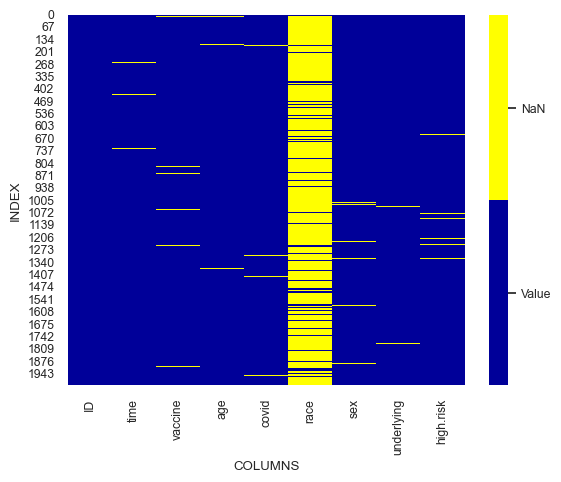

,ID,time,vaccine,age,covid,race,sex,underlying,high.risk
NaN,0.0,0.014,0.01,0.009,0.011,0.865,0.015,0.0125,0.015
Value,1.0,0.986,0.99,0.991,0.989,0.135,0.985,0.9875,0.985


In [303]:
viewna(df)

## __2__ Removal Methods

Clearly, `race` has a lot of missing data. I stared at the heatmap very intensely for a long while and concluded that for the `race` column at least, there is no clear pattern within the surrounding columns that could be correlated with how it's missing. So I decided to do _attribute deletion_ due to the high proportionality of missing data. 

In [306]:
df.drop(columns="race", inplace=True)

df

,ID,time,vaccine,age,covid,sex,underlying,high.risk
0,17247,15.0,1.0,25.0,0.0,M,No,Yes
1,17126,365.0,1.0,19.0,0.0,M,No,No
2,16124,365.0,0.0,21.0,0.0,M,No,No
3,16428,365.0,0.0,18.0,0.0,F,No,No
4,17496,365.0,1.0,20.0,0.0,F,No,No
...,...,...,...,...,...,...,...,...
1995,16992,365.0,1.0,19.0,0.0,M,No,No
1996,17133,365.0,1.0,32.0,0.0,F,Yes,No
1997,16304,268.0,0.0,23.0,1.0,F,No,No
1998,15942,76.0,0.0,24.0,1.0,F,Yes,No


## __3__ Imputation Methods

Despite deleting the `race` column, there's still some missing data scattered across the other columns. If the missing data is due to MCAR, then honestly we can additionally do complete case deletion (_i.e._, row deletion) and we'd be done since doing so would not introduce any bias later in our predictive modelling, but let's assume the worse, that is, the missing data is due to MAR. Then in this case, we would implement either $k$-NN or MICE to impute our data. I've chosen MICE because it's generally known to be more robust as an imputing tool.

We can delete the `ID` columns since it is nearly guaranteed to be irrelevant as a cause for the missing data in the other columns. And for the column selected honestly all columns seem relevant to help fill in each of their missing data, except for `covid` because in the context of why we want to impute data (for constructing a predictive model on whether or not a student contracted COVID or not) using the actual answer to impute other data is a clear bias (similar I suppose to a column variable in a OLS model causing data leakage/multicolinearity).

In [324]:
df.drop(columns="ID", inplace=True)

impute(df, ["time", "vaccine", "age", "sex", "underlying", "high.risk"], "mice")

,time,vaccine,age,covid,sex,underlying,high.risk
0,15.0,1.0,25.0,0.0,M,No,Yes
1,365.0,1.0,19.0,0.0,M,No,No
2,365.0,0.0,21.0,0.0,M,No,No
3,365.0,0.0,18.0,0.0,F,No,No
4,365.0,1.0,20.0,0.0,F,No,No
...,...,...,...,...,...,...,...
1995,365.0,1.0,19.0,0.0,M,No,No
1996,365.0,1.0,32.0,0.0,F,Yes,No
1997,268.0,0.0,23.0,1.0,F,No,No
1998,76.0,0.0,24.0,1.0,F,Yes,No


## References

<ul style="list-style: none">
    <li>[1] https://stackoverflow.com/questions/38836154/discrete-legend-in-seaborn-heatmap-plot</li>
    <li>[2] https://stackoverflow.com/questions/29530232/how-to-check-if-any-value-is-nan-in-a-pandas-dataframe</li>
    <li>[3] https://stackoverflow.com/questions/53697127/how-to-set-absolutely-new-index-to-pandas-dataframe-not-based-on-previous-index</li>
</ul>